Tutorial for how to run the detector tomography.
Import files and libraries

In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from nct_lib import unit_test as ut
from nct_lib import support_functions as sf
from nct_lib import nct
from nct_lib.qst import QST  
from nct_lib.povm import POVM
#from nct_lib import measurement_functions as mf


----------------------------
Error corrected BME.
600000 POVM calibration shots.
30000 QST shots.
5 QST averages.
----------------------------
No synthetic noise.
	Number of MLE iterations: 50, final distance 3.0953017926549364e-13
	Number of MLE iterations: 50, final distance 1.712519015484304e-14
	Number of MLE iterations: 50, final distance 1.942890293094024e-16
Runtime of DT reconstruction 0.51999831199646
Distance between reconstructed and noisy POVM: 0.002274597808587603
Distance between reconstructed and noisy POVM: 0.0002043266723424919
Distance between reconstructed and noisy POVM: 0.001586326167259039
POVM calibration complete.
----------------------------
Generated data.
Start corrected QST.
Completed run 1/5. Final infidelity: 0.002875198685106106.
Completed run 2/5. Final infidelity: 0.0014819936042445025.
Completed run 3/5. Final infidelity: 0.001392624807971865.
Completed run 4/5. Final infidelity: 0.002441228356309111.
Completed run 5/5. Final infidelity: 0.003751538532

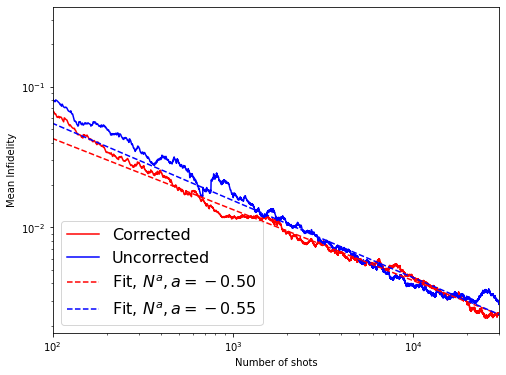

In [4]:

bool_exp_measurements=False # Whether to call experimental sampling function or not
n_qubits=1
n_QST_shots=10**4 # Number of shots for each spin measurement pr true state (total=3*n_QST_shots nativly)
n_calibration_shots=10**5 # Calibration shots for DT, each calibration state and each spin measurment
n_cores=4 # Available cores for 
n_averages=5 # Only used if you generate true states generate_random_pure_state()


noise_mode=0 # Noise mode if using synthetic measurement
# 0: No noise
# 1: Depolarizing noise
# 2: Stronger depolarized noise
# 3: Amplitude damping
# 4: Constant rotation around x-axis


# Example of how to take in angles and convert them to to true states.
list_of_true_angles=np.array([[np.pi/2,0],[np.pi/2,np.pi],
                    [np.pi/2,np.pi/2],[np.pi/2,3*np.pi/2],
                    [0,0],[np.pi,0]])

list_of_true_states=np.array([sf.get_projector_from_angles(np.array([angles])) for angles in list_of_true_angles])


# Alternativly you can generate states using the built in random pure state generator.
list_of_true_states=np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_averages)])


# Optinally you can also defined calibration states used for DT, default is all Pauli states
calibration_angles=np.array([[[np.pi/2,0]],[[np.pi/2,np.pi]],
                            [[np.pi/2,np.pi/2]],[[np.pi/2,3*np.pi/2]],
                            [[0,0]],[[np.pi,0]]])
calibration_states=np.array([sf.get_density_matrix_from_angles(angle) for angle in calibration_angles])


# What is required from the experimental 
# dictionary is the name of the sampling function defined in this notebook.
# 

def exp_measurement_function(n_shots,POVM_angles,true_state_angles,exp_dictionary):
    print(exp_dictionary)
    """
    It takes in:
    n_shots as a int,
    POVM_angles as np array [ [ [theta,phi], [orthogonal angles] ] ] 
    true state angles as np array [[theta,phi]]

    return: 
    np array with index 0 for first POVM angels and 1 for orhtogonal state. 
    e.g. [1,0,0,1,1,0,0,0,...]
    """
    return np.random.randint(low=0,high=2,size=(n_shots))


exp_dictionary={"measurement_function": exp_measurement_function }

# Once everything is defined you call nct (Noice corrected tomography)

uncorrected_infidelity, corrected_infidelity,rho_estm=nct.nct(n_qubits,n_QST_shots,n_calibration_shots,
                                                            list_of_true_states,bool_exp_measurements=bool_exp_measurements,
                                                            calibration_states=calibration_states,exp_dictionary=exp_dictionary,
                                                            n_cores=n_cores, noise_mode=noise_mode)
print(uncorrected_infidelity)
print(corrected_infidelity)
# returns a list of mean infidelities [len(list_of_true_states) x nQSTShots],
# list of uncorrected infidelities and reconstructed quantum states.

In [7]:
# Basic QST example
# We use a different POVM object, using pauli-6 looks like this
n_qubits=1
POVM_list=POVM.generate_Pauli_POVM(n_qubits)

# Define the estimator
qst=QST(POVM_list,list_of_true_states,n_QST_shots,1,bool_exp_measurements,exp_dictionary,n_cores=n_cores)

print("Start generating data.")
qst.generate_data()


print("Start QST.")
qst.perform_BME()
rho_estm=qst.get_rho_estm()
infidelity=qst.get_infidelity()
print(infidelity)

Start generating data.
Start QST.
Completed run 1/5. Final infidelity: 0.0005338793166369538.
Completed run 2/5. Final infidelity: 0.002248729674302119.
Completed run 3/5. Final infidelity: 0.0019807958149548055.
Completed run 4/5. Final infidelity: 0.002753453617512114.
Completed run 5/5. Final infidelity: 0.0021382883788716445.
[[4.36452982e-01 4.36036818e-01 4.17902264e-01 ... 5.34953021e-04
  5.34409275e-04 5.33879317e-04]
 [3.76889960e-01 3.91427557e-01 3.19154493e-01 ... 2.25718052e-03
  2.25587416e-03 2.24872967e-03]
 [5.98671486e-01 4.93553419e-01 4.16053392e-01 ... 1.99067856e-03
  1.98571622e-03 1.98079581e-03]
 [5.32620239e-01 5.83064593e-01 6.71165301e-01 ... 2.75476436e-03
  2.75663866e-03 2.75345362e-03]
 [5.27844395e-01 5.24292946e-01 4.29878880e-01 ... 2.13854147e-03
  2.14102603e-03 2.13828838e-03]]


Loaded QST settings from results/2023-05-16_14-12-53_b8427fdc-b6f7-43ed-ab39-9a6188880872/
Completed run 1/1. Final infidelity: 0.0024556287417176748.
Completed run 1/1. Final infidelity: 0.00263547251052787.


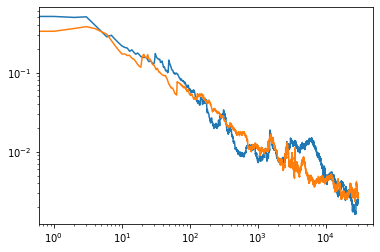

In [2]:
# Code to load data from files
base_path="results/2023-05-16_14-12-53_b8427fdc-b6f7-43ed-ab39-9a6188880872/"
#base_path="2023-05-15_20-30-21_24344c1c-bde1-4098-ae7f-18bb601924bf/"
qst=QST.load_data(base_path)


# Perform BME with the Uncorrected POVM
qst.perform_BME()
uncorrected_infidelity=qst.get_infidelity()


# Perform BME with corrected POVM
use_corrected_POVM=True
qst.perform_BME(use_corrected_POVM)
corrected_infidelity=qst.get_infidelity()
#print(infidelity)
for i in range (len(uncorrected_infidelity)):
    plt.plot(np.arange(len(uncorrected_infidelity[i])),uncorrected_infidelity[i])
    plt.plot(np.arange(len(corrected_infidelity[i])),corrected_infidelity[i])
plt.yscale('log')
plt.xscale('log')
plt.show()
